# Policy-Gradient Algorithms on *CartPole* — Notebook Guide

This single **Jupyter notebook** walks through two classic Monte-Carlo policy-gradient methods implemented in PyTorch:

| Section | Algorithm | Baseline Type | Networks Trained |
|---------|-----------|---------------|------------------|
| **REINFORCE** | Vanilla Monte-Carlo Policy Gradient | Moving average of episode returns | Policy π |
| **REINFORCE + Critic** | One-step Actor-Critic | Learned value function V(s) | Policy π and Value V |

The environment is **Gymnasium’s `CartPole-v1`**—simple enough to run quickly, yet rich enough to illustrate how returns and advantages drive policy updates.

---

## Key RL Concepts Illustrated

| Concept | Where to look | What it means |
|---------|---------------|---------------|
| **Episode roll-out** | `while not done:` loop | Sample actions \(a_t \sim \pi_\theta(s_t)\) until the pole falls or the time limit expires. |
| **Discounted return \(G_t\)** | `for rt in reversed(rewards):` | \(G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots\) with \(\gamma = 0.99\). |
| **Baseline & Advantage** | *Plain* REINFORCE: moving-average baseline.<br>*Actor-Critic*: learn \(V_\phi(s)\). | Advantages reduce gradient variance:<br>\(A_t = G_t - b_t\) or \(A_t = G_t - V_\phi(s_t)\). |
| **Loss functions** | Policy loss for both:<br>\(\mathcal{L}_\pi = -\sum_t \log\pi_\theta(a_t\mid s_t) A_t\)<br>Value loss (actor-critic only):<br>\(\mathcal{L}_V = \lVert V_\phi(s_t) - G_t\rVert_2^2\) | Drives π to favor high-advantage actions; trains V to approximate returns. |
| **Optimization** | Separate Adam optimizers | One for policy, one for critic (when present), stepped once per episode. |

---

## Result
Loss: -12    Return: 500    Episode length: 500

In [1]:
!pip install "gymnasium"

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

action space: Discrete(2)
initial state: [0.04586143 0.04797461 0.01249856 0.02462727]


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
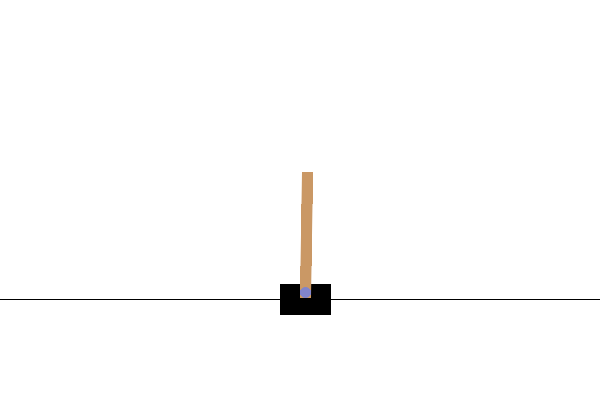

In [3]:
env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode="rgb_array")
# getting action space
print(f"action space: {env.action_space}")
s0, a0 = env.reset()
print(f"initial state: {s0}")
env.render()


### Policy Model with No Value Model

REINFORCE algorithm, simplest and strong baseline
* Policy Gradient
* baseline is moving average of previous returns

In [4]:
class Policy(nn.Module):
  def __init__(self, state_dim, action_space_cardinality, dropout_rate=0.2):
    super().__init__()
    self.l1 = nn.Linear(state_dim, 32*state_dim)
    self.l2 = nn.Linear(32*state_dim, state_dim)
    self.l3 = nn.Linear(state_dim, action_space_cardinality)
    self.dropout = nn.Dropout(dropout_rate)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, state):
    x = self.l1(self.dropout(state))
    x = F.relu(x)
    x = self.l2(self.dropout(x))
    # x = F.relu(x)
    x = self.l3(self.dropout(x))
    return self.softmax(x)


pi = Policy(env.observation_space.shape[0], env.action_space.n, dropout_rate=0.0)
probs = pi(torch.tensor(s0))
at = torch.distributions.Categorical(probs).sample()

In [5]:
optimizer = torch.optim.AdamW(pi.parameters(), lr = 0.001)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pi = pi.to(device)
baseline = 0.0
for ep in range(500):
  # Play
  done = False
  st, _ = env.reset()
  states = []
  rewards = []
  actions = []
  while not done:
    with torch.no_grad():          # ← graph not kept
      inputs = torch.tensor(st).to(device)
      probs = pi(inputs)
      at = torch.distributions.Categorical(probs).sample()
      next_s, rt, terminated, truncated, _ = env.step(at.detach().cpu().item())
      done = terminated or truncated
      rewards.append(rt)
      actions.append(at)
      states.append(st)
      st = next_s

  # Compute Return
  gamma = 0.99
  ret = 0
  Gt = []
  for _i, rt in enumerate(reversed(rewards)):
    ret = rt + gamma*ret
    Gt.insert(0, ret)

  Gt = torch.tensor(Gt)
  baseline = 0.1*Gt.mean() + 0.9*baseline
  advantages = Gt - baseline

  # calculate loss
  optimizer.zero_grad()
  log_probs = torch.stack([torch.distributions.Categorical(pi(torch.tensor(st).to(device))).log_prob(at) for st, at in zip(states, actions)])
  loss = -(log_probs*advantages.to(device)).sum()
  loss.backward()
  optimizer.step()

  if ep % 50 == 0:
    print(f"Loss: {loss:.00f}\tReturn: {Gt[0]:.0f}\tNumber of actions: {len(rewards)}")
    print("----------------------")

Loss: 61	Return: 13	Number of actions: 14
----------------------
Loss: 4	Return: 21	Number of actions: 24
----------------------
Loss: 110	Return: 37	Number of actions: 46
----------------------
Loss: -257	Return: 24	Number of actions: 27
----------------------
Loss: 4730	Return: 96	Number of actions: 326
----------------------
Loss: 2588	Return: 97	Number of actions: 351
----------------------
Loss: -1087	Return: 94	Number of actions: 279
----------------------
Loss: -1399	Return: 96	Number of actions: 312
----------------------
Loss: 120	Return: 99	Number of actions: 500
----------------------
Loss: 421	Return: 99	Number of actions: 500
----------------------


## Policy Model with Value Model
Introducing Actor-Critic (A2C)

Using state Value V(sₜ)

Aₜ = Gₜ - V(sₜ)

In [24]:
class Policy(nn.Module):
  def __init__(self, state_dim, action_space_cardinality, dropout_rate=0.2):
    super().__init__()
    self.l1 = nn.Linear(state_dim, 32*state_dim)
    self.l2 = nn.Linear(32*state_dim, state_dim)
    self.l3 = nn.Linear(state_dim, action_space_cardinality)
    self.dropout = nn.Dropout(dropout_rate)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, state):
    x = self.l1(self.dropout(state))
    x = F.relu(x)
    x = self.l2(self.dropout(x))
    # x = F.relu(x)
    x = self.l3(self.dropout(x))
    return self.softmax(x)


pi = Policy(env.observation_space.shape[0], env.action_space.n, dropout_rate=0.0)
probs = pi(torch.tensor(s0))
at = torch.distributions.Categorical(probs).sample()

In [25]:
class ValueModel(nn.Module):
  def __init__(self, state_dim):
    super().__init__()
    self.l1 = nn.Linear(state_dim, 32*state_dim)
    self.l2 = nn.Linear(32*state_dim, 1)


  def forward(self, s):
    x = self.l1(s)
    x = F.relu(x)
    x = self.l2(x)
    return x

V = ValueModel(env.observation_space.shape[0])

In [26]:
pi_optimizer = torch.optim.AdamW(pi.parameters(), lr = 0.001)
v_optimizer = torch.optim.AdamW(V.parameters(), lr = 0.001)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pi = pi.to(device)
V = V.to(device)
baseline = 0.0
for ep in range(500):
  """
  Play
  """
  done = False
  st, _ = env.reset()
  states = []
  rewards = []
  actions = []
  while not done:
    with torch.no_grad():          # ← graph not kept
      inputs = torch.tensor(st).to(device)
      probs = pi(inputs)
      at = torch.distributions.Categorical(probs).sample()
    next_s, rt, terminated, truncated, _ = env.step(at.detach().cpu().item())
    done = terminated or truncated
    rewards.append(rt)
    actions.append(at)
    states.append(st)
    st = next_s

  """
  Compute Return
  """
  # critic values
  states_tensor = torch.stack([torch.tensor(st, dtype=torch.float32, device=device) for st in states])
  values = V(states_tensor)

  # Gt
  gamma = 0.99
  ret = 0
  Gt = []
  for _i, rt in enumerate(reversed(rewards)):
    ret = rt + gamma*ret
    Gt.insert(0, ret)

  # Advantages
  Gt = torch.tensor(Gt, dtype=torch.float32, device=device)


  """
  calculate loss
  """
  # Value model
  v_optimizer.zero_grad()
  mse_loss = F.mse_loss(values.squeeze(), Gt, reduction='mean')
  mse_loss.backward()
  v_optimizer.step()

  # Policy
  advantages = (Gt - values).detach() # no grad from policy into value model
  pi_optimizer.zero_grad()
  log_probs = torch.stack([torch.distributions.Categorical(pi(torch.tensor(st).to(device))).log_prob(at) for st, at in zip(states, actions)])
  loss = -(log_probs*advantages.to(device)).sum()
  loss.backward()
  pi_optimizer.step()




  if ep % 50 == 0:
    print(f"Loss: {loss:.00f}\tReturn: {Gt[0]:.0f}\tNumber of actions: {len(rewards)}")
    print("----------------------")

Loss: 4707	Return: 21	Number of actions: 24
----------------------
Loss: 706	Return: 12	Number of actions: 13
----------------------
Loss: 4319	Return: 23	Number of actions: 26
----------------------
Loss: 6182	Return: 28	Number of actions: 32
----------------------
Loss: 192066	Return: 66	Number of actions: 108
----------------------
Loss: 1551140	Return: 92	Number of actions: 253
----------------------
Loss: 2943241	Return: 97	Number of actions: 341
----------------------
Loss: 6657498	Return: 99	Number of actions: 500
----------------------
Loss: 5623267	Return: 99	Number of actions: 500
----------------------
Loss: 43404	Return: 72	Number of actions: 127
----------------------
